In [11]:
import os
import json
import numpy as np
import time

try:
    import dill as pickle
except ImportError:
    import pickle

import pandas as pd
from PIL import Image, ImageDraw
import math
import random
import cv2

from config import Config
import utils

In [12]:
HOME = os.getcwd()
IMAGE_DIR = '/root/Lab/data/Cityscapes/leftImg8bit'
ANN_DIR = '/root/Lab/data/Cityscapes/gtFine'

In [13]:
def image_ann_paths(ret = True, pickle_files = False):
    """creates dictionaries for path to images and annotation files
    optional pickle files can be created
    """
    image_dct = {}
    ann_dct = {}
    for directory in ["train","val","test"]:
        images = []
        ann = []
        image_path = os.path.join(IMAGE_DIR, directory)
        ann_path = os.path.join(ANN_DIR, directory)
        cities = [d for d in os.listdir(image_path)]
        for city in cities:
            print("appending data: {} city from {} directory".format(city,directory))
            city_path = os.path.join(image_path, city)
            city_ann_path = os.path.join(ann_path, city)
            for file in os.listdir(city_path):
                images.append(os.path.join(city_path,file))
                filename = "_".join(file.split("_")[:3])
                filename += "_gtFine_polygons.json"
                ann.append(os.path.join(city_ann_path, filename))
        image_dct[directory] = images
        ann_dct[directory] = ann
        
        if pickle_files:
            pickle.dump(images,open("image_{}.pickle".format(directory), "wb"))
            pickle.dump(ann,open("ann_{}.pickle".format(directory), "wb"))
    if ret:        
        return image_dct, ann_dct

In [14]:
images, annotations = image_ann_paths(pickle_files=True)

appending data: jena city from train directory
appending data: stuttgart city from train directory
appending data: ulm city from train directory
appending data: dusseldorf city from train directory
appending data: darmstadt city from train directory
appending data: zurich city from train directory
appending data: bremen city from train directory
appending data: bochum city from train directory
appending data: hamburg city from train directory
appending data: tubingen city from train directory
appending data: aachen city from train directory
appending data: krefeld city from train directory
appending data: hanover city from train directory
appending data: weimar city from train directory
appending data: strasbourg city from train directory
appending data: cologne city from train directory
appending data: erfurt city from train directory
appending data: monchengladbach city from train directory
appending data: frankfurt city from val directory
appending data: munster city from val direct

In [15]:
images = pickle.load(open("image_train.pickle", "rb"))
annotations = pickle.load(open("ann_train.pickle", "rb"))
labels = ['bicycle', 'bicyclegroup', 'bridge', 'building', 'bus', 'car',
        'caravan', 'cargroup', 'dynamic', 'ego vehicle', 'fence', 'ground',
          'guard rail', 'license plate', 'motorcycle', 'motorcyclegroup',
          'out of roi', 'parking', 'person', 'persongroup', 'pole',
          'polegroup', 'rail track', 'rectification border', 'rider',
          'ridergroup', 'road', 'sidewalk', 'sky', 'static', 'terrain',
          'traffic light', 'traffic sign', 'trailer', 'train', 'truck',
          'truckgroup', 'tunnel', 'vegetation', 'wall']

In [16]:
len(labels)

40

87


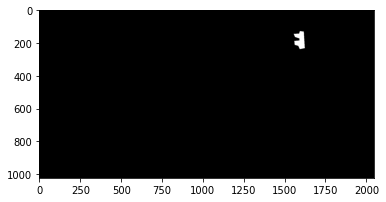

In [17]:
image_path = '/root/Lab/data/Cityscapes/leftImg8bit/train/erfurt/erfurt_000000_000019_leftImg8bit.png'
#image_path = dataset.image_info[image_id]['path']
image_path = image_path.replace("leftImg8bit","gtFine")
image_path = image_path.replace(".png", "_polygons.json")

dct = json.load(open(image_path,'r'))
num_instances = len(dct['objects'])
print(num_instances)
width = 2048
height = 1024

instance_masks = []
class_ids = []

for i in range(num_instances):
    instance = dct['objects'][i]
    class_ids.append(instance['label'])
    poly = instance['polygon']
    polygon = [tuple(pt) for pt in poly]
    img = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    mask = np.array(img)
    instance_masks.append(mask)
    
import matplotlib.pyplot as plt
plt.imshow(instance_masks[74], cmap = 'gray')


In [18]:
'/root/Lab/data/Cityscapes/leftImg8bit/train/erfurt/erfurt_000000_000019_leftImg8bit.png'.replace("leftImg8bit","gtFine")

'/root/Lab/data/Cityscapes/gtFine/train/erfurt/erfurt_000000_000019_gtFine.png'

In [19]:
class CityscapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cityscapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 40  # background + 3 shapes
    
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 2048
    
config = CityscapesConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[512 512]
 [256 256]
 [128 128]
 [ 64  64]
 [ 32  32]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  2048
IMAGE_MIN_DIM                  1024
IMAGE_PADDING                  True
IMAGE_SHAPE                    [2048 2048    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           cityscapes
NUM_CLASSES                    41
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINI

In [20]:
class CityscapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_cityscapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        for class_id, class_name in enumerate(set(labels)):
            self.add_class("cityscapes", i + 1, class_name)

        # Add images
        for i, path in enumerate(images):
            self.add_image("cityscapes", image_id=i, path=path)
            
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "cityscapes":
            return info["cityscapes"]
        else:
            super(self.__class__).image_reference(self, image_id)
            
    #def load_mask(self, image_id):
        #return mask, image_ids

In [21]:
HOME = os.getcwd()
TRAIN_DIR = '/root/Lab/data/Cityscapes/gtFine/train'
VAL_DIR = '/root/Lab/data/Cityscapes/gtFine/val'
TEST_DIR = '/root/Lab/data/Cityscapes/gtFine/test'

In [22]:
def pickle_data(color_file = "color.pickle", label_file = "labels.pickle", 
                polygon_file = "polygons.pickle"):
    colors = []
    labels = []
    polygons = []
    for directory in [TRAIN_DIR,VAL_DIR,TEST_DIR]:
        cities = [d for d in os.listdir(directory) if d != 'placeholder.txt']
        for city in cities:
            tic = time.time()
            city_path = os.path.join(directory, city)
            json_files = [j for j in os.listdir(city_path) if j[-4:] == 'json']
            for file in json_files:
                j = os.path.join(city_path,file)
                with open(j,'r') as f:
                    dct = json.load(f)
                    for i in range(len(dct['objects'])):
                        colors.append(j)
                        objects = dct['objects'][i]
                        labels.append(objects['label'])
                        polygons.append(objects['polygon'])
            print("Completed City:",city,"in",str(time.time() - tic),"seconds")
        print("Completed Directory", directory.split("/")[-1])
    pickle.dump(colors,open(color_file, "wb"))
    pickle.dump(labels, open(label_file, "wb"))
    pickle.dump(polygons, open(polygon_file, "wb"))
    return polygons
    
    
polygons = pickle_data()

Completed City: jena in 0.43302249908447266 seconds
Completed City: stuttgart in 1.331052541732788 seconds
Completed City: ulm in 0.14615106582641602 seconds
Completed City: dusseldorf in 0.7504558563232422 seconds
Completed City: darmstadt in 0.7604267597198486 seconds
Completed City: zurich in 0.4324822425842285 seconds
Completed City: bremen in 1.5211269855499268 seconds
Completed City: bochum in 0.32929205894470215 seconds
Completed City: hamburg in 1.8965463638305664 seconds
Completed City: tubingen in 0.3096919059753418 seconds
Completed City: aachen in 0.5242164134979248 seconds
Completed City: krefeld in 0.9918110370635986 seconds
Completed City: hanover in 0.6681523323059082 seconds
Completed City: weimar in 0.3155052661895752 seconds
Completed City: strasbourg in 2.146744966506958 seconds
Completed City: cologne in 0.35590648651123047 seconds
Completed City: erfurt in 0.24722957611083984 seconds
Completed City: monchengladbach in 1.4556546211242676 seconds
Completed Directory

In [23]:
def pickle_rois(polygons, roi_file = "roi.pickle"):
    rois = []
    count = 0
    for poly in polygons:
        polygon = [tuple(pt) for pt in poly]
        xs = [x for x,y in polygon]
        ys = [y for x,y in polygon]
        x_min = np.min(xs)
        x_max = np.max(xs)
        y_min = np.min(ys)
        y_max = np.max(ys)
        roi = [x_min,y_min,x_max,y_max]
        roi.append(rois)
        count += 1
        if count % 50000 == 0:
            print('{} more rois to process'.format(len(polygons) - count))

    pickle.dump(rois,open(roi_file, "wb"))
    
    
pickle_rois(polygons)

237465 more rois to process
187465 more rois to process
137465 more rois to process
87465 more rois to process
37465 more rois to process
